In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
Image_size = 256
Batch_size = 32
Channels = 3
Epochs = 150

In [4]:
data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-classification-mri/Training',
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size)

Found 2870 files belonging to 4 classes.


2022-12-25 04:46:32.671425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 04:46:32.672402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 04:46:33.010564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 04:46:33.011471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 04:46:33.012296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [5]:
classes = data.class_names
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [6]:
len(data)

90

In [7]:
for image_batch, label_batch in data.take(1) :
    print ( image_batch.shape)
    print (label_batch.numpy( ))

2022-12-25 04:46:38.249081: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 256, 256, 3)
[2 1 0 1 3 2 1 3 3 0 2 3 0 0 3 3 3 1 0 0 0 1 1 0 3 0 0 1 1 1 2 1]


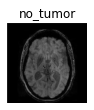

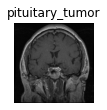

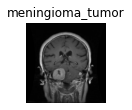

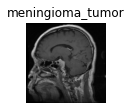

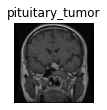

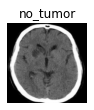

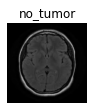

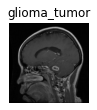

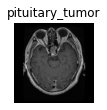

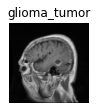

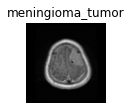

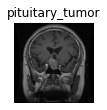

In [8]:
for image_batch, label_batch in data.take(1):
    for x in range(12):
        plt.figure(figsize = (10,10))
        ax =plt.subplot(4,6,x+1)
        plt.imshow(image_batch[x].numpy().astype('uint8'))
        plt.title(classes[label_batch[x]])
        plt.axis('off')
        plt.show()

In [9]:
def get_dataset_partitions_tf (dataset,train_split=0.9,val_split=0.1,shuffle = True,shuffle_size = 10000):
    dataset_size  = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)

    train_size= int(train_split * dataset_size)
    validation_size= int(val_split * dataset_size)

    train_ds = dataset.take(train_size)

    validation_ds= dataset.skip(train_size) .take(validation_size)

     

    return train_ds, validation_ds
    

In [10]:
train_ds,validation_ds = get_dataset_partitions_tf(data)

In [11]:
len(train_ds)

81

In [12]:
len(validation_ds)

9

In [13]:
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_ds= validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
num_classes = 4
input_shape =(Batch_size,Image_size,Image_size,Channels)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  
  #data_augmentation,
  
  tf.keras.layers.Conv2D(6, (3,3), activation='relu',input_shape =(Batch_size,Image_size,Image_size,Channels)),
  tf.keras.layers.MaxPooling2D(pool_size=3,strides=3),
  
  
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=3,strides=3),
  
  tf.keras.layers.Dropout(rate=0.5),
  
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=3,strides=3),
  
  tf.keras.layers.Dropout(rate=0.3),
  
  tf.keras.layers.Flatten(),
  
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(rate=0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.3),
  tf.keras.layers.Dense(256, activation='relu'),
  #tf.keras.layers.Dropout(rate=0.3),
  tf.keras.layers.Dense(128, activation='relu'),
  #tf.keras.layers.Dropout(rate=0.3),
  tf.keras.layers.Dense(64, activation='relu'),
  
  tf.keras.layers.Dense(num_classes,activation='softmax')
])


model.build(input_shape)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 6)         168       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 84, 84, 6)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 82, 82, 32)          1760      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 27, 27, 32)          0         
_________________________________________________________________
dropout (Dropout)            (32, 27, 27, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 25, 25, 64)          1

In [17]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [19]:
hist = model.fit(train_ds, epochs=Epochs,batch_size = Batch_size,validation_data=validation_ds, callbacks=[callbacks])

Epoch 1/150


2022-12-25 04:46:53.722048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 73 of 10000
2022-12-25 04:46:54.942140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-12-25 04:46:54.942207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1000
2022-12-25 04:46:54.942945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-12-25 04:46:56.283169: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


81/81 [==============================] - 33s 111ms/step - loss: 1.2456 - accuracy: 0.4384 - val_loss: 1.1871 - val_accuracy: 0.4748
Epoch 2/150
81/81 [==============================] - 2s 21ms/step - loss: 1.0112 - accuracy: 0.5391 - val_loss: 0.9224 - val_accuracy: 0.5504
Epoch 3/150
81/81 [==============================] - 2s 20ms/step - loss: 0.7735 - accuracy: 0.6522 - val_loss: 0.7093 - val_accuracy: 0.7122
Epoch 4/150
81/81 [==============================] - 2s 20ms/step - loss: 0.6493 - accuracy: 0.7149 - val_loss: 0.6435 - val_accuracy: 0.7662
Epoch 5/150
81/81 [==============================] - 2s 20ms/step - loss: 0.5457 - accuracy: 0.7649 - val_loss: 0.5179 - val_accuracy: 0.8309
Epoch 6/150
81/81 [==============================] - 2s 21ms/step - loss: 0.4840 - accuracy: 0.7959 - val_loss: 0.4512 - val_accuracy: 0.8813
Epoch 7/150
81/81 [==============================] - 2s 20ms/step - loss: 0.4557 - accuracy: 0.8176 - val_loss: 0.4895 - val_accuracy: 0.8201
Epoch 8/150
81/8

In [20]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

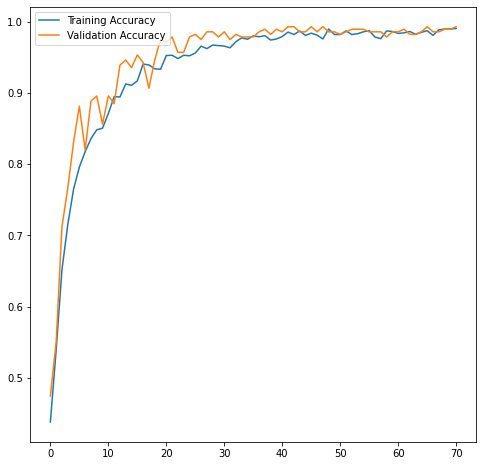

In [21]:
plt.figure(figsize=(8,8))
plt.plot(accuracy,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend(loc="upper left")
plt.show()

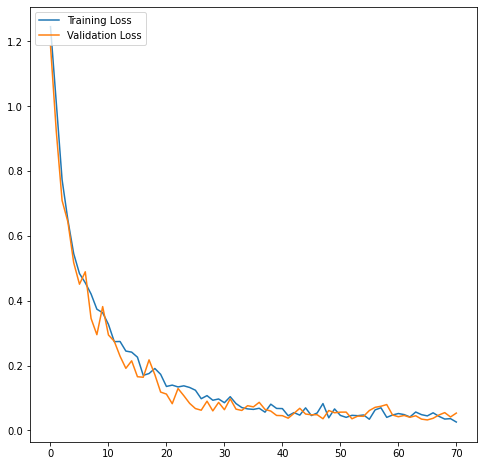

In [22]:
plt.figure(figsize=(8,8))
plt.plot(loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend(loc="upper left")
plt.show()

In [23]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/brain-tumor-classification-mri/Testing',
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size)

Found 394 files belonging to 4 classes.


In [24]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 2s 58ms/step - loss: 2.1905 - accuracy: 0.7335


first image to predict
actual label:  no_tumor
predicted label:  no_tumor


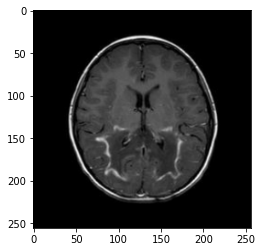

In [25]:
for images_batch,labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label: ',classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('predicted label: ',classes[np.argmax(batch_prediction[0])])